In [1]:
! mkdir -p /root/.pip

In [2]:
%%writefile /root/.pip/pip.conf
[global]
index-url=http://ftp.daumkakao.com/pypi/simple
trusted-host=ftp.daumkakao.com

Overwriting /root/.pip/pip.conf


In [3]:
import time
import datetime
import os
import ast
import sys
import pytz
import random
import shutil
# import splitfolders
import copy
from glob import glob
from tqdm import tqdm
from pprint import pprint

import warnings
import requests

import gc
import math
import numpy as np
import pandas as pd

import cv2
from PIL import Image
# import pydicom as pdm
import pickle
import yaml
import h5py
import json
import matplotlib.pyplot as plt
# import seaborn as sns

import albumentations as albu
import torch
# import torchtuples as tt
from sklearn import metrics

import torchvision
import timm 
# import pretrainedmodels

In [4]:
!pip install timm

Looking in indexes: http://ftp.daumkakao.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
    
print('Using PyTorchversion:', torch.__version__, 'Device:', DEVICE)

Using PyTorchversion: 1.10.0+cu113 Device: cuda


In [6]:
DATA_DIR = '/ainode/dataset/train/'
case_lst = [path.split('/')[-1].split('_')[0] for path in glob(DATA_DIR+'flow/*')]
case_lst.sort()

In [7]:
p_annot_df = pd.read_csv(f'./DATA/annot.csv')
p_annot_df['ID'] = list(range(len(p_annot_df)))
p_annot_df.head()

,Event_Number,Event_Label,Start_Time,End_Time,Start_Epoch,End_Epoch,Duration(second),FPS,Frames,Case,ID
0,0,Wake,2020/05/02 22:20:30.000,2020/05/02 22:21:00.000,1,2,30.0,5.0,"[0, 150]",A2020-EM-01-0001,0
1,4,Wake,2020/05/02 22:21:00.000,2020/05/02 22:21:30.000,2,3,30.0,5.0,"[150, 300]",A2020-EM-01-0001,1
2,5,Wake,2020/05/02 22:21:30.000,2020/05/02 22:22:00.000,3,4,30.0,5.0,"[300, 450]",A2020-EM-01-0001,2
3,7,Wake,2020/05/02 22:22:00.000,2020/05/02 22:22:30.000,4,5,30.0,5.0,"[450, 600]",A2020-EM-01-0001,3
4,8,Wake,2020/05/02 22:22:30.000,2020/05/02 22:23:00.000,5,6,30.0,5.0,"[600, 750]",A2020-EM-01-0001,4


In [8]:
IMG_DIR = '/ainode/dataset/train/'
FLOW_DIR = '/ainode/dataset/train/flow/'
RGB_DIR = '/ainode/dataset/train/rgb/'

In [9]:
p_annot_df['Event_Label'].iloc[1200:2200].value_counts()

Light Sleep    609
Deep Sleep     245
Wake           146
Name: Event_Label, dtype: int64

## Train Val Test Split

In [10]:
DATA_NUM = 1000

In [11]:
y = p_annot_df.Event_Label[:DATA_NUM]
X = p_annot_df[['ID','Start_Epoch','Case', 'FPS', 'Frames']][:DATA_NUM]

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.1)
len(X_train),len(X_val),len(X_test)

(810, 90, 100)

In [13]:
np.unique(y_train, return_counts=True),\
np.unique(y_val, return_counts=True),\
np.unique(y_test, return_counts=True)

((array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
  array([224, 376, 210])),
 (array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
  array([28, 37, 25])),
 (array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
  array([25, 52, 23])))

## DataLoader

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import sklearn

In [15]:
import torchvision.transforms as transforms

In [16]:
class Dataset(BaseDataset):
    
    def __init__(
            self,  
            X,
            y,
            imgtype, # 'rgb','flow_x','flow_y'
            labels,
            augmentation=None, 
            preprocessing=None,
    ):
        self.epochs = X['Start_Epoch'].tolist()
        self.cases = X['Case'].tolist()
        self.fps = X['FPS'].tolist()
        self.frames = X['Frames'].tolist()
        self.imgpaths = [f'{IMG_DIR}{imgtype[:4]}/{self.cases[idx]}_video_01/' for idx in range(len(self.epochs))]
        self.imgtype = imgtype
        self.labels = labels
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
        le = sklearn.preprocessing.LabelEncoder()
        self.level = le.fit_transform(y.tolist())
    
    def __getitem__(self, i):
        
        # read data
        imgs_path = self.imgpaths[i] # 해당 케이스 이미지 다 들어가있는 디렉토리
        
        if 'flow' in self.imgtype:
            img_lst = glob(imgs_path+f'/{self.imgtype}*.jpg')
        else:
            img_lst = glob(imgs_path+'/img*.jpg')
        img_lst.sort()
        frames = ast.literal_eval(self.frames[i])
        img_lst = img_lst[frames[0]:frames[1]] #img_lst[self.frames[i][0]:self.frames[i][0]+150]
        images = []
        
        for idx, path in enumerate(img_lst):
            if idx % 5 == 0:
#                 image = np.array(Image.open(path).convert('RGB'))
#                 if self.augmentation:
#                     sample = self.augmentation(image=image)
#                     image = sample['image'].convert('RGB')
                image = np.array(Image.open(path).resize((128,128)).convert('RGB'))
                image = np.transpose(image, (2, 0, 1))
                images.append(image)
        
        images = np.array(images)
        images = np.transpose(images, (1,0,2,3))
        images = torch.Tensor(images)
        
        level = torch.as_tensor(self.level[i])

#         if self.preprocessing:
#             sample = self.preprocessing(images = images)
#             images = sample['images']
        
        
        return images, level

        
    def __len__(self):
        return len(self.epochs)

In [17]:
def get_validation_augmentation():
    test_transform = [transforms.Resize((256, 256)), 
    ]
    return albu.Compose(test_transform)


# def to_tensor(x, **kwargs):
#     return x.transpose(3, 0, 1, 2).astype('float32')

In [18]:
def to_tensor(x, **kwargs):
    return x.transpose(3, 0, 1, 2).astype('float32')


def get_preprocessing():
    _transform = [
        albu.Lambda(images=to_tensor),
    ]
    return albu.Compose(_transform)

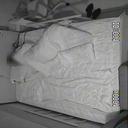

In [19]:
dataset = Dataset(X_train[:5], y_train[:5], 'rgb', ['Wake', 'Light Sleep','Deep Sleep'],)
#                   augmentation = get_validation_augmentation()) #, preprocessing = get_preprocessing())
image, level = dataset[4]

np.array(image).shape
# dataset.cases, dataset.epochs
# np.unique(np.array(images[6]))
# Image.fromarray(np.array(image).astype('uint8'))
Image.fromarray(np.transpose(np.array(image).astype('uint8')[:,0,:,:], (2,1,0)))

In [20]:
BATCH_SIZE = 16

In [21]:
imagetype = 'rgb' # 'rgb', 'flow_x','flow_y'
labels = ['Wake', 'Light Sleep','Deep Sleep']
train_dataset = Dataset(X_train, y_train, imagetype, labels)
val_dataset = Dataset(X_val, y_val, imagetype, labels)
test_dataset = Dataset(X_test, y_test, imagetype, labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset)

In [22]:
print(len(train_loader))

Xtrain, ytrain = next(iter(train_loader))
print('Xtrain:', Xtrain.size(), 'type:', Xtrain.type())
print('ytrain:', ytrain.size(), 'type:', ytrain.type())

print()
print(len(val_loader))

Xval, yval = next(iter(val_loader))
print('Xval:', Xval.size(), 'type:', Xval.type())
print('yval:', yval.size(), 'type:', yval.type())

print()
print(len(test_loader))

Xtest, ytest = next(iter(test_loader))
print('Xtest:', Xtest.size(), 'type:', Xtest.type())
print('ytest:', ytest.size(), 'type:', ytest.type())

51
Xtrain: torch.Size([16, 3, 30, 128, 128]) type: torch.FloatTensor
ytrain: torch.Size([16]) type: torch.LongTensor

6
Xval: torch.Size([16, 3, 30, 128, 128]) type: torch.FloatTensor
yval: torch.Size([16]) type: torch.LongTensor

100
Xtest: torch.Size([1, 3, 30, 128, 128]) type: torch.FloatTensor
ytest: torch.Size([1]) type: torch.LongTensor


In [23]:
%%time
Xtrain, ytrain = next(iter(train_loader))

CPU times: user 6.26 ms, sys: 35.4 ms, total: 41.7 ms
Wall time: 10.6 s


In [24]:
ytrain

tensor([1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 0, 2, 0, 1])

In [25]:
pltsize = 4                         

plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(len(Xtrain[:10])):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    img = np.transpose(Xtrain.numpy()[i][:,0,:,:], (2,1,0))[:,:,0]
    plt.imshow(img,cmap="gray_r")
#     plt.title('Class: ' + str(y_train[i].item()))
    plt.title('Class: ' + str(ytrain[i])[-2])

## Train Model

In [26]:
CLASSES = 3

In [27]:
resnet3d = torchvision.models.video.r3d_18(pretrained = True, progress = True)

In [28]:
import torch.nn as nn  

In [29]:
# classifier layer output shape --> number of classes

num_ftrs = resnet3d.fc.in_features
resnet3d.fc = nn.Linear(num_ftrs,CLASSES)
resnet3d.fc = nn.Sequential(resnet3d.fc, nn.Softmax(),)

resnet3d.fc

Sequential(
  (0): Linear(in_features=512, out_features=3, bias=True)
  (1): Softmax(dim=None)
)

In [30]:
LR = 0.00005
EPOCHS = 100
TRAIN_PATIENCE = 10

In [31]:
model = resnet3d.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.LamabdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,
                                verbose=False)

AttributeError: module 'torch.optim.lr_scheduler' has no attribute 'LamabdaLR'

In [ ]:
model

In [ ]:
# https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
# this function is used during training process, to calculation the loss and accuracy

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
image, label = next(iter(train_loader))
image.shape, label.shape

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()                                                 # assign train mode to the model
    
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()                                     # 과거에 이용한 Mini-Batch내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient값이 optimizer에 할당되어 있으므로 optimizer의 Gradient 초기화
        output = model(image)
        loss = criterion(output, label)
        loss.backward()                                           # Back propagation으로 계산된 Gradient 값을 각 parameter에 할당
        optimizer.step()                                          # parameter update
        scheduler.step()
        prediction = output.max(1, keepdim = True)[1]             # predicted labels in tensor
        
        train_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
        train_loss.update(loss.item())
        
        if batch_idx % log_interval == 0:                         # print log
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
    
    total_loss_train.append(train_loss.avg)
    total_acc_train.append(train_acc.avg)

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    
    with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            loss = criterion(output, label)
            prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
    
            val_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
            val_loss.update(loss.item())
    
    total_acc_val.append(val_acc.avg)
    total_loss_val.append(val_loss.avg)
    
    return val_loss.avg, val_acc.avg   

In [ ]:
best_val_acc = 0
best_val_loss = 100
epoch = 0
total_loss_train, total_acc_train = [],[]
total_loss_val, total_acc_val = [],[]

for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 20)
    val_loss, val_acc = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tVal Loss: {:.4f}, \tVal Accuracy: {:.2f} %\n".format(Epoch, val_loss, val_acc))
    
    # monitoring test accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epoch = Epoch
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, val_loss, val_acc))
        print('*****************************************************')
    elif Epoch > epoch + TRAIN_PATIENCE:
        break
        
#     # monitoring test loss
#     if test_loss < best_val_loss:
#         best_val_loss = test_loss
#         epoch = Epoch
#         print('*****************************************************')
#         print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, test_loss, test_accuracy))
#         print('*****************************************************')
#     elif Epoch > epoch + TRAIN_PATIENCE:
#         break

In [ ]:
best_val_acc

# Evaluation

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_loss_val, label = 'test loss')
fig2.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_acc_val, label = 'test accuracy')
plt.legend()
plt.show()

In [ ]:
min(total_loss_val), max(total_acc_val)

# Save Model

In [ ]:
!mkdir ./saved-models

In [ ]:
PATH = "./saved-models/model-epoch{epoch:02d}-loss_val{loss_val:.2f}-acc_val{acc_val:.2f}.pt".format(epoch = epoch, loss_val = total_loss_val[epoch] , acc_val = total_acc_val[epoch])

# torch.save(model.state_dict, PATH)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(), # trained parameters
            'optimizer_state_dict': optimizer.state_dict(), # this contains buffers and parameters that are updated as the model trains
            'accuracy':best_val_acc, #'loss': best_val_loss,
            }, PATH)

In [ ]:
resnet3d = torchvision.models.video.r3d_18(pretrained = True, progress = True)

In [ ]:
# classifier layer output shape --> number of classes
CLASSES = 3

num_ftrs = resnet3d.fc.in_features
resnet3d.fc = nn.Linear(num_ftrs,CLASSES)
resnet3d.fc = nn.Sequential(resnet3d.fc, nn.Softmax(),)

In [ ]:
# best_model = resnet3d.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_model = resnet3d

In [ ]:
WORK_DIR = './'

In [ ]:
DIR = WORK_DIR + 'saved-models/'

weights = os.listdir(DIR)
weights.sort()
# val_losses = [filename.split('-')[2].split('val')[1] for filename in weights]
val_losses = [filename.split('-')[2].split('val')[1] for filename in weights] #[1:]]
best_weight = val_losses.index(min(val_losses))
# path = './saved_models/' + weights[best_weight]
path = DIR + weights[best_weight] #+1] # '.ipynb_checkpoints' 파일이 맨 앞에 있기 때문에 index가 하나씩 밀린다.

# best_model = torch.load(DIR+'model-epoch00-loss_val1.08-acc_val0.46.pt')
checkpoint = torch.load(path)
best_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
# loss = checkpoint['loss']

best_model.eval()

# Inference

In [ ]:
!ls /mnt/dataset/test/annotation

In [ ]:
!ls /ainode/dataset/test/flow

In [ ]:
!ls /ainode/dataset/test/rgb

# Evaluate Model

In [ ]:
true_labels = []
predicted_labels = []
predicted_values = []

# best_model.eval()
    
test_loss = AverageMeter()
test_acc = AverageMeter()

with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
    for image, label in test_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = best_model(image)
        loss = criterion(output, label)
        prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
        
        true_labels.append(label)
        predicted_labels.append(prediction)
        predicted_values.append(output)
        
        test_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
        test_loss.update(loss.item())
        
test_loss.avg, test_acc.avg

In [ ]:
len(predicted_values)

In [ ]:
# tensor to array form
true_test_lst = []
predicted_test_lst = []
predicted_value_lst = []

for i in range(len(test_loader)):
    t_labels = true_labels[i].cpu().numpy()
    true_test_lst += list(t_labels)
    
    p_labels = predicted_labels[i].cpu().numpy()[:,0]
    predicted_test_lst += list(p_labels)
    
    p_values = predicted_values[i].cpu().numpy()
    predicted_value_lst += list(p_values)
    
true_test_arr = np.array(true_test_lst)
predicted_test_arr = np.array(predicted_test_lst)
predicted_value_arr = np.array([list(arr) for arr in predicted_value_lst])
    
true_test_arr[:20], predicted_test_arr[:20], predicted_value_arr[:20]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [ ]:
# Confusion Matrix
tick_labels = ['Wake', 'Light Sleep','Deep Sleep']

cm = confusion_matrix(true_test_arr, predicted_test_arr)
ax = sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

In [ ]:
# Classification Report

labels = ['Wake', 'Light Sleep','Deep Sleep']

print(classification_report(true_test_arr, predicted_test_arr, target_names = labels))

In [ ]:
# roc curve for classes

fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(true_test_arr == i, predicted_value_arr[:, i])
    
# plotting
plt.plot(fpr[1], tpr[1], linestyle='--',color='blue', label='Positive: Opacity / Negative: Normal') # Sensitivity: 비정상 중에 비정상으로 predict된 비율 / Specificity: 정상 중에 정상으로 predict된 비율
plt.title('ROC curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='best') 